# Prédire l'absence d'un patient à un rendez-vous

## Importation des librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from time import strftime
import statistics

## Chargement du jeu de données

In [2]:
df = pd.read_excel('./Kaggle_donnees_modifiees.xlsx')
df.head(3)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Completed-show,Provenance urgence,Type de la visite
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,Completed,0,appointment
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,Completed,0,appointment
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,Completed,0,appointment


In [3]:
df.shape

(110527, 16)

## Préparation des données

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   PatientId           110527 non-null  float64
 1   AppointmentID       110527 non-null  int64  
 2   Gender              110527 non-null  object 
 3   ScheduledDay        110527 non-null  object 
 4   AppointmentDay      110527 non-null  object 
 5   Age                 110527 non-null  int64  
 6   Neighbourhood       110527 non-null  object 
 7   Scholarship         110527 non-null  int64  
 8   Hipertension        110527 non-null  int64  
 9   Diabetes            110527 non-null  int64  
 10  Alcoholism          110527 non-null  int64  
 11  Handcap             110527 non-null  int64  
 12  SMS_received        110527 non-null  int64  
 13  Completed-show      110527 non-null  object 
 14  Provenance urgence  110527 non-null  int64  
 15  Type de la visite   110527 non-nul

Le jeu de données ne contient pas de valeurs nulles. 

La colonne "**PatientId**" contient des float, il faut donc les convertir en int.

In [5]:
df.PatientId = df.PatientId.astype('int64')
df.PatientId.dtypes

dtype('int64')

La colonne "**Completed-show**" contient des string. Pour les convertir en booléens on affiche toutes les valeurs uniques.

In [6]:
df["Completed-show"].unique()

array(['Completed', 'Noshow'], dtype=object)

On renomme la colonne "**Completed-show**" et on convertit les données de la colonne en "0" ou "1".

In [7]:
df = df.rename(columns={"Completed-show": "NoShow"})
df['NoShow'] = df['NoShow'].replace({'Completed': 0, 'Noshow': 1})

On renomme la colonne "**Gender**" en "**IsMale**" et on convertit les données en "0" ou "1".

In [8]:
df = df.rename(columns={"Gender": "IsMale"})
df['IsMale'] = df['IsMale'].replace({'F': 0, 'M': 1})

In [9]:
df.describe

<bound method NDFrame.describe of               PatientId  AppointmentID  IsMale          ScheduledDay  \
0        29872499824296        5642903       0  2016-04-29T18:38:08Z   
1       558997776694438        5642503       1  2016-04-29T16:08:27Z   
2         4262962299951        5642549       0  2016-04-29T16:19:04Z   
3          867951213174        5642828       0  2016-04-29T17:29:31Z   
4         8841186448183        5642494       0  2016-04-29T16:07:23Z   
...                 ...            ...     ...                   ...   
110522    2572134369293        5651768       0  2016-05-03T09:15:35Z   
110523    3596266328735        5650093       0  2016-05-03T07:27:33Z   
110524   15576631729893        5630692       0  2016-04-27T16:03:52Z   
110525   92134931435557        5630323       0  2016-04-27T15:09:23Z   
110526  377511518121127        5629448       0  2016-04-27T13:30:56Z   

              AppointmentDay  Age      Neighbourhood  Scholarship  \
0       2016-04-29T00:00:00Z   6

Un **âge** ne peut pas être négatif donc on supprime les lignes ayant un âge inférieur à 0.

In [10]:
df = df[df["Age"] >= 0]

On crée deux nouvelles colonnes : 
* "**PreviousAppointment**" qui contient le nombre de précédents rendez-vous que le patient a pris
* "**PreviousNoShow**" qui calcule le taux d'absence du patient

In [11]:
df['PreviousAppointment'] = df.sort_values(by = ['PatientId','ScheduledDay']).groupby(['PatientId']).cumcount()
df['PreviousNoShow'] = (df[df['PreviousAppointment'] > 0].sort_values(['PatientId', 'ScheduledDay']).groupby(['PatientId'])['NoShow'].cumsum() / df[df['PreviousAppointment'] > 0]['PreviousAppointment'])

C:\Users\SALOMC~1\AppData\Local\Temp/ipykernel_29220/368054795.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PreviousAppointment'] = df.sort_values(by = ['PatientId','ScheduledDay']).groupby(['PatientId']).cumcount()
C:\Users\SALOMC~1\AppData\Local\Temp/ipykernel_29220/368054795.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PreviousNoShow'] = (df[df['PreviousAppointment'] > 0].sort_values(['PatientId', 'ScheduledDay']).groupby(['PatientId'])['NoShow'].cumsum() / df[df['PreviousAppointmen

In [12]:
df.head(3)

,PatientId,AppointmentID,IsMale,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,NoShow,Provenance urgence,Type de la visite,PreviousAppointment,PreviousNoShow
0,29872499824296,5642903,0,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,0,0,appointment,1,0.0
1,558997776694438,5642503,1,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,0,0,appointment,1,0.0
2,4262962299951,5642549,0,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,0,0,appointment,1,0.0


On complète les données manquantes de la colonne "**PreviousNoShow**" par 0.

In [13]:
df['PreviousNoShow'] = df['PreviousNoShow'].fillna(0)

C:\Users\SALOMC~1\AppData\Local\Temp/ipykernel_29220/2023432327.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PreviousNoShow'] = df['PreviousNoShow'].fillna(0)


In [14]:
df.sample(10)

,PatientId,AppointmentID,IsMale,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,NoShow,Provenance urgence,Type de la visite,PreviousAppointment,PreviousNoShow
36060,73269736196167,5609113,0,2016-04-20T15:10:13Z,2016-05-11T00:00:00Z,75,TABUAZEIRO,0,1,0,0,0,1,0,0,appointment,0,0.0
64789,55544338249,5585813,0,2016-04-14T20:36:32Z,2016-05-10T00:00:00Z,41,JARDIM CAMBURI,0,0,0,0,0,1,0,0,appointment,0,0.0
109565,54559924916154,5773727,0,2016-06-06T07:28:53Z,2016-06-08T00:00:00Z,7,ARIOVALDO FAVALESSA,1,0,0,0,0,0,1,0,appointment,5,0.4
72342,732498986588399,5645749,0,2016-05-02T10:21:08Z,2016-05-05T00:00:00Z,65,MARIA ORTIZ,0,0,0,0,0,1,0,0,appointment,1,0.0
31246,15616562417625,5639651,1,2016-04-29T09:21:31Z,2016-05-10T00:00:00Z,52,DO MOSCOSO,0,0,0,0,0,0,0,0,appointment,1,0.0
48476,66536575187423,5648794,0,2016-05-02T16:34:34Z,2016-05-30T00:00:00Z,63,JARDIM DA PENHA,0,1,0,0,0,1,0,0,appointment,0,0.0
16361,287819413396927,5604753,0,2016-04-20T08:18:00Z,2016-05-04T00:00:00Z,42,TABUAZEIRO,0,1,0,0,0,1,0,0,appointment,0,0.0
5385,117261814482,5720462,1,2016-05-19T13:52:02Z,2016-05-24T00:00:00Z,53,RESISTÊNCIA,0,0,0,0,0,1,0,0,appointment,1,0.0
77363,7897429832879,5667194,0,2016-05-06T07:30:36Z,2016-05-11T00:00:00Z,68,SANTO ANTÔNIO,0,1,0,0,0,0,0,0,appointment,0,0.0
48825,91755284167863,5662933,1,2016-05-05T09:14:26Z,2016-05-05T00:00:00Z,21,JARDIM DA PENHA,0,0,0,0,0,0,0,0,appointment,1,0.0


Les colonnes "**ScheduledDay**" et "**AppointmentDay**" contiennent des strings. On les convertit au format date-time pour pouvoir les analyser plus facilement. On peut également extraire la date, le jour de la semaine, le mois et l'heure avec ce format.

In [15]:
df.ScheduledDay = pd.to_datetime(df.ScheduledDay)
df.AppointmentDay = pd.to_datetime(df.AppointmentDay)
df[['ScheduledDay','AppointmentDay']].dtypes

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


ScheduledDay      datetime64[ns, UTC]
AppointmentDay    datetime64[ns, UTC]
dtype: object

On crée des nouvelles colonnes à partir des colonnes "**ScheduledDay**" et "**AppointmentDay**" : 
* **ScheduledHour :** heure de la prise de rendez-vous
* **AppointmentTime :** heure du rendez-vous
* **ScheduledDate :** date de la prise de rendez-vous
* **AppointmentDate :** date du rendez-vous
* **AppointmentWeekDay :** jour de la semaine du rendez-vous
* **AppointmentMonth :** mois du rendez-vous
* **WaitingDays :** délai entre la prise de rendez-vous et le rendez-vous (en jours)

In [16]:
df['ScheduledHour'] = pd.to_datetime(df.ScheduledDay).dt.hour
df['AppointmentTime'] = pd.to_datetime(df.AppointmentDay).dt.time

df['ScheduledDay'] = df['ScheduledDay'].dt.date
df['AppointmentDay'] = df['AppointmentDay'].dt.date

df['AppointmentWeekDay'] = pd.to_datetime(df.AppointmentDay).dt.day_name()
df['AppointmentMonth'] = pd.to_datetime(df.AppointmentDay).dt.month_name()

C:\Users\SALOMC~1\AppData\Local\Temp/ipykernel_29220/4066668240.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ScheduledHour'] = pd.to_datetime(df.ScheduledDay).dt.hour
C:\Users\SALOMC~1\AppData\Local\Temp/ipykernel_29220/4066668240.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AppointmentTime'] = pd.to_datetime(df.AppointmentDay).dt.time
C:\Users\SALOMC~1\AppData\Local\Temp/ipykernel_29220/4066668240.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [17]:
# Délai entre la prise de rendez-vous et le rendez-vous
df['WaitingDays'] = df.AppointmentDay - df.ScheduledDay

# Conversion en int
df.WaitingDays = df.WaitingDays.astype('str')
df.WaitingDays = df.WaitingDays.apply(lambda x: x.split()[0])
df.WaitingDays = df.WaitingDays.astype('int64')

C:\Users\SALOMC~1\AppData\Local\Temp/ipykernel_29220/1367202781.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['WaitingDays'] = df.AppointmentDay - df.ScheduledDay
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


On normalise les colonnes "**Age**", "**WaitingDays**", "**ScheduledHour**", "**PreviousAppointment**" et "**PreviousNoShow**".

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
std=StandardScaler()

columns = ['Age', 'WaitingDays', 'ScheduledHour', 'PreviousAppointment', 'PreviousNoShow']
new_columns = ['AgeScaled', 'WaitingDaysScaled', 'ScheduledHourScaled', 'PreviousAppointmentScaled', 'PreviousNoShowScaled']
scaled = std.fit_transform(df[columns])
scaled = pd.DataFrame(scaled, columns=new_columns, index= df.index.values)

df = df.merge(scaled, left_index=True, right_index=True, how = "left")

In [20]:
df.head(3)

,PatientId,AppointmentID,IsMale,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,...,ScheduledHour,AppointmentTime,AppointmentWeekDay,AppointmentMonth,WaitingDays,AgeScaled,WaitingDaysScaled,ScheduledHourScaled,PreviousAppointmentScaled,PreviousNoShowScaled
0,29872499824296,5642903,0,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,...,18,00:00:00,Friday,April,0,1.077926,-0.667572,2.246598,-0.069077,-0.352744
1,558997776694438,5642503,1,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,...,16,00:00:00,Friday,April,0,0.818297,-0.667572,1.624742,-0.069077,-0.352744
2,4262962299951,5642549,0,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,...,16,00:00:00,Friday,April,0,1.077926,-0.667572,1.624742,-0.069077,-0.352744


Les valeurs de la colonne "**AppointmentTime**" ont l'air de toutes être identiques. On le vérifie.

In [21]:
df.AppointmentTime.nunique()

1

Il y a bien qu'une seule valeur donc on supprime cette colonne qui devient inutile.

In [22]:
df.drop(columns='AppointmentTime',inplace=True)

On supprime la colonne "**Provence urgence**" qui ne nous est pas utile. 

In [23]:
df.drop(columns='Provenance urgence',inplace=True)

On vérifie s'il existe des lignes qui ont une date de prise de rendez-vous après leur date de rendez-vous, ce qui n'a pas de sens. S'il y en a, on les affiche.

In [24]:
df_error = df[df.ScheduledDay > df.AppointmentDay]
df_error

,PatientId,AppointmentID,IsMale,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,...,PreviousNoShow,ScheduledHour,AppointmentWeekDay,AppointmentMonth,WaitingDays,AgeScaled,WaitingDaysScaled,ScheduledHourScaled,PreviousAppointmentScaled,PreviousNoShowScaled
27033,7839272661752,5679978,1,2016-05-10,2016-05-09,38,RESISTÊNCIA,0,0,0,...,0.00,10,Monday,May,-1,0.039411,-0.733125,-0.240827,-0.324608,-0.352744
55226,7896293967868,5715660,0,2016-05-18,2016-05-17,19,SANTO ANTÔNIO,0,0,0,...,0.25,14,Tuesday,May,-1,-0.782747,-0.733125,1.002886,0.697517,0.659705
64175,24252258389979,5664962,0,2016-05-05,2016-05-04,22,CONSOLAÇÃO,0,0,0,...,1.00,13,Wednesday,May,-1,-0.652933,-0.733125,0.691957,-0.069077,3.697051
71533,998231581612122,5686628,0,2016-05-11,2016-05-05,81,SANTO ANTÔNIO,0,0,0,...,1.00,13,Thursday,May,-6,1.900084,-1.060887,0.691957,-0.069077,3.697051
72362,3787481966821,5655637,1,2016-05-04,2016-05-03,7,TABUAZEIRO,0,0,0,...,0.00,6,Tuesday,May,-1,-1.302004,-0.733125,-1.484539,-0.324608,-0.352744


On supprime donc ces lignes. 

In [25]:
df = df[~(df.ScheduledDay > df.AppointmentDay)]

On vérifie s'il y a des doublons.

In [26]:
df.duplicated().sum()

0

On renomme certaines colonnes pour coder plus facilement.

In [27]:
labels = {'PatientId':'PatientID', 'Hipertension':'Hypertension',
          'Handcap':'Handicap', 'SMS_received':'SMSreceived'}
df.rename(columns=labels,inplace=True)

In [28]:
df.sample(3)

,PatientID,AppointmentID,IsMale,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,...,PreviousNoShow,ScheduledHour,AppointmentWeekDay,AppointmentMonth,WaitingDays,AgeScaled,WaitingDaysScaled,ScheduledHourScaled,PreviousAppointmentScaled,PreviousNoShowScaled
57980,8411951752775,5681892,1,2016-05-10,2016-05-10,79,NOVA PALESTINA,0,0,0,...,0.0,15,Tuesday,May,0,1.813541,-0.667572,1.313814,-0.324608,-0.352744
61268,677388639316,5686237,0,2016-05-11,2016-05-25,22,GRANDE VITÓRIA,0,0,0,...,1.0,12,Wednesday,May,14,-0.652933,0.250162,0.381029,-0.069077,3.697051
53470,59573646256238,5717441,1,2016-05-19,2016-05-19,5,SANTA HELENA,0,0,0,...,0.0,7,Thursday,May,0,-1.388547,-0.667572,-1.173611,0.186455,-0.352744


## Analyse exploratoire des données

On teste si les données ont une corrélation les unes avec les autres

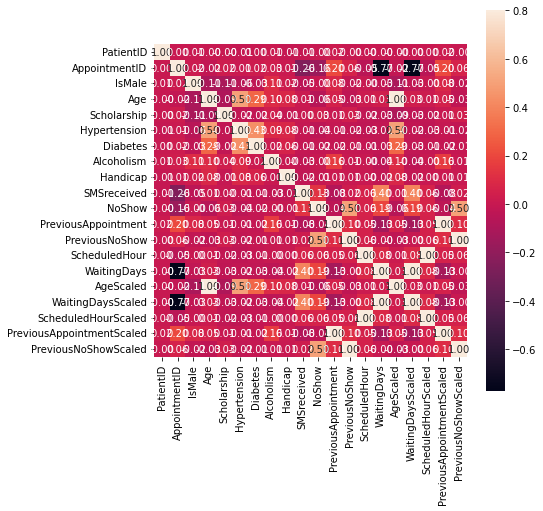

In [29]:
correlation = df.corr()
fig, axes = plt.subplots(figsize=(7,7))
sns.heatmap(correlation, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10});

La matrice fait ressortir trois corrélations :
* Hypertension-Age
* Hypertension-Diabetes
* Diabetes-Age

Ces résultats sont médicalement attendus. Il n'y a pas de corrélation forte entre une caractéristique quelconque et l'absence à un rendez-vous.

On teste si le sexe, le fait d'avoir reçu un SMS de confirmation et le fait d'avoir une aide financière ont un impact sur l'absence à un rendez-vous

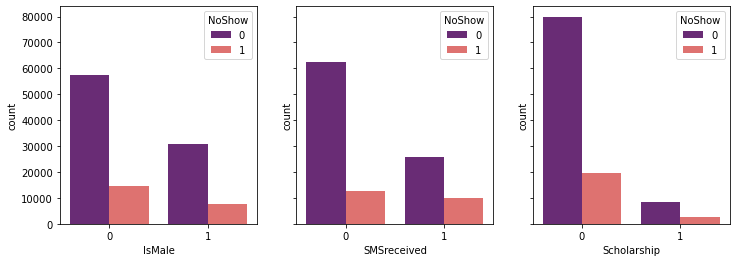

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True)
sns.countplot(x='IsMale', data=df, hue='NoShow', ax=ax1, palette='magma');
sns.countplot(x='SMSreceived', data=df, hue='NoShow', ax=ax2, palette='magma');
sns.countplot(x='Scholarship', data=df, hue='NoShow', ax=ax3, palette='magma');
fig.set_figwidth(12)
fig.set_figheight(4)

Les femmes prennent plus de rendez-vous que les hommes. Le taux d’absence est plutôt similaire pour les hommes et les femmes.

De manière surprenante, le taux d'absence est plus élevé pour les patients ayant reçu un SMS que pour ceux n'en ayant pas reçu.

On teste si le handicap est corrélé à l'absence à un rendez-vous

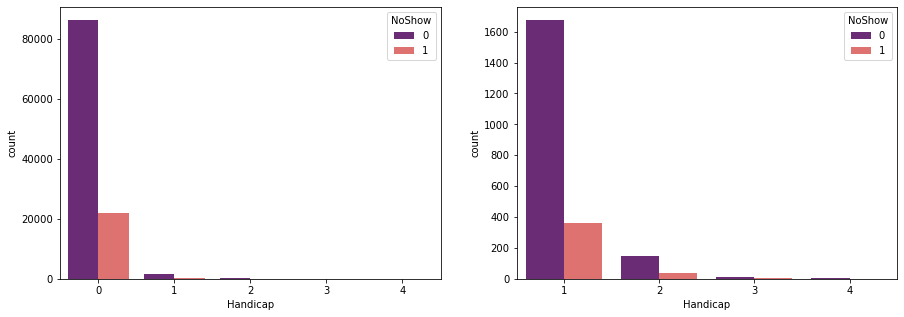

In [31]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)
sns.countplot(x='Handicap', data=df, hue='NoShow', ax=ax1, palette='magma')
sns.countplot(x='Handicap', data=df[-(df.Handicap == 0)], hue='NoShow', ax=ax2, palette='magma')
fig.set_figwidth(15)
fig.set_figheight(5)

Il n'y a pas l'air d'avoir de corrélation entre le handicap et l'absence à un rendez-vous

On teste si le jour de la semaine du rendez-vous est corrélé à l'absence à un rendez-vous

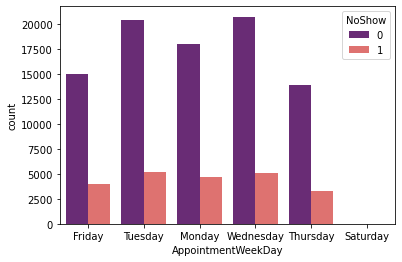

In [32]:
sns.countplot(x='AppointmentWeekDay', data=df, hue='NoShow', palette='magma')
fig.set_figwidth(15)
fig.set_figheight(5)

Il n'y a pas l'air d'avoir de corrélation entre le jour de la semaine du rendez-vous et l'absence à un rendez-vous.

On teste si l'heure de la prise du rendez-vous est corrélée à l'absence à un rendez-vous

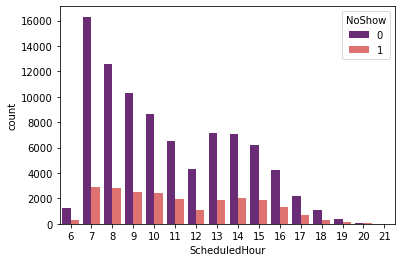

In [33]:
sns.countplot(x='ScheduledHour', data=df, hue='NoShow', palette='magma')
fig.set_figwidth(15)
fig.set_figheight(5)

Il n'y a pas l'air d'avoir de corrélation entre l'heure de la prise du rendez-vous et l'absence à un rendez-vous.

On teste si le mois du rendez-vous est corrélé à l'absence à un rendez-vous

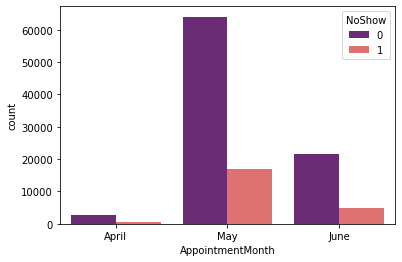

In [34]:
sns.countplot(x='AppointmentMonth', data=df, hue='NoShow', palette='magma')
fig.set_figwidth(15)
fig.set_figheight(5)

Nous avons seulement les mois d'avril, mai et juin ce qui ne nous permet pas de savoir si le mois du rendez-vous a un impact sur l'absence du patient à un rendez-vous.

On teste si le fait d'avoir de l'hypertension est corrélé à l'absence à un rendez-vous

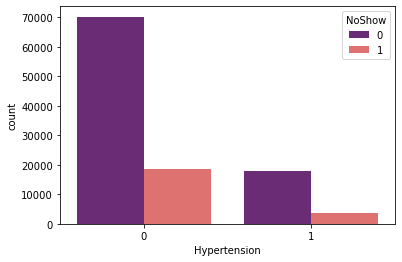

In [35]:
sns.countplot(x='Hypertension', data=df, hue='NoShow', palette='magma')
fig.set_figwidth(15)
fig.set_figheight(5)

Le fait d'avoir de l'hypertension a l'air de diminuer le taux d'absence à un rendez-vous.

## Prétraitement des données

On supprime les colonnes "**AppointmentID**", "**Provenance urgence**" et "**Type de la visite**" qui ne nous servent à rien.

In [36]:
df = df.drop(columns=['AppointmentID', 'Type de la visite'], axis=1)

On supprime les colonnes "**AppointmentDay**" et "**ScheduledDay**" qui ne nous sont plus utiles. 

In [37]:
df = df.drop(columns=['AppointmentDay', 'ScheduledDay'], axis=1)

On transforme les données catégoricielles en données numériques avec l'encodage one-hot.

In [38]:
df = pd.get_dummies(df, columns=['Neighbourhood','Handicap', 'AppointmentWeekDay', 'AppointmentMonth'], 
                    prefix=['Neighbourhood','Handicap', 'AppointmentWeekDay', 'AppointmentMonth'])

## Répartition des données

Si différents rendez-vous d'un même patient ont lieu en même temps dans les groupes d'entraînement et de test, une fuite de données peut se produire. On doit donc en tenir compte dans la répartition des données.

On enlève la colonne "**NoShow**" du jeu de données de prédiction.

In [39]:
X = df.drop('NoShow', axis=1)

On supprime les colonnes "**Age**", "**WaitingDays**" and "**ScheduledHour**" car elles ont été normalisées. On utilisera donc les colonnes avec les données normalisées.

In [40]:
X = X.drop(columns = ['Age', 'WaitingDays', 'ScheduledHour', 'PreviousAppointment', 'PreviousNoShow'], axis=1)

In [41]:
y = df.NoShow

In [42]:
from sklearn.model_selection import GroupShuffleSplit

On prend **20%** des données pour le test et **80%** pour l'entraînement.

In [43]:
gs = GroupShuffleSplit(n_splits=2, test_size=.2, random_state=0)
train_ix, test_ix = next(gs.split(X, y, groups=X.PatientID))

In [44]:
len(train_ix)

88562

In [45]:
X_train = X.iloc[train_ix]
X_train = X_train.drop('PatientID',1)
y_train = y.iloc[train_ix]

X_test = X.iloc[test_ix]
X_test = X_test.drop('PatientID',1)
y_test = y.iloc[test_ix]

C:\Users\SALOMC~1\AppData\Local\Temp/ipykernel_29220/1639604458.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = X_train.drop('PatientID',1)
C:\Users\SALOMC~1\AppData\Local\Temp/ipykernel_29220/1639604458.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test = X_test.drop('PatientID',1)


In [46]:
print("Train set data shape: " + str(X_train.shape))
print("Test set data shape: " + str(X_test.shape))

Train set data shape: (88562, 106)
Test set data shape: (21959, 106)


## Comparaison des modèles

### KNeighbors

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Test score :  0.8402021949997723
Classification report : 
              precision    recall  f1-score   support

           0       0.86      0.96      0.90     17392
           1       0.70      0.40      0.51      4567

    accuracy                           0.84     21959
   macro avg       0.78      0.68      0.71     21959
weighted avg       0.83      0.84      0.82     21959



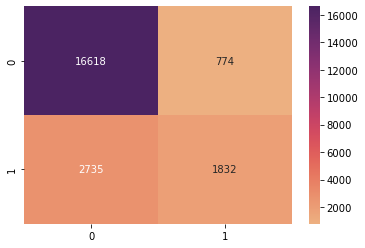

In [48]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
print("Test score : ", model.score(X_test, y_test))
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(f"Classification report : \n{report}")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True,fmt='d',cmap="flare");

### Naive Bayes

In [49]:
from sklearn.naive_bayes import GaussianNB

Test score :  0.46199735871396697
Classification report : 
              precision    recall  f1-score   support

           0       0.88      0.37      0.52     17392
           1       0.25      0.81      0.39      4567

    accuracy                           0.46     21959
   macro avg       0.57      0.59      0.45     21959
weighted avg       0.75      0.46      0.49     21959



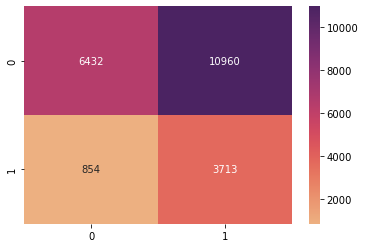

In [50]:
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)
print("Test score : ", model_nb.score(X_test, y_test))
y_pred_nb = model_nb.predict(X_test)
report_nb = classification_report(y_test, y_pred_nb)
print(f"Classification report : \n{report_nb}")
cm = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm, annot=True,fmt='d',cmap="flare");

### Decision tree

In [51]:
from sklearn.tree import DecisionTreeClassifier

Test score :  0.8115579033653627
Classification report : 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     17392
           1       0.55      0.54      0.54      4567

    accuracy                           0.81     21959
   macro avg       0.71      0.71      0.71     21959
weighted avg       0.81      0.81      0.81     21959



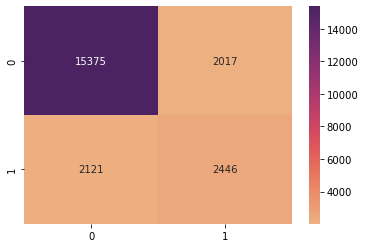

In [52]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)
print("Test score : ", model_dt.score(X_test, y_test))
y_pred_dt = model_dt.predict(X_test)
report_dt = classification_report(y_test, y_pred_dt)
print(f"Classification report : \n{report_dt}")
cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True,fmt='d',cmap="flare");

### Random forest

In [53]:
from sklearn.ensemble import RandomForestClassifier

Test score :  0.8506762603032925
Classification report : 
              precision    recall  f1-score   support

           0       0.86      0.97      0.91     17392
           1       0.76      0.41      0.53      4567

    accuracy                           0.85     21959
   macro avg       0.81      0.69      0.72     21959
weighted avg       0.84      0.85      0.83     21959



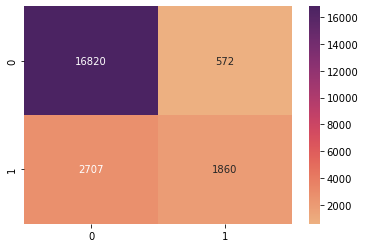

In [54]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
print("Test score : ", model_rf.score(X_test, y_test))
y_pred_rf = model_rf.predict(X_test)
report_rf = classification_report(y_test, y_pred_rf)
print(f"Classification report : \n{report_rf}")
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True,fmt='d',cmap="flare");

### XGboost

In [55]:
from sklearn.ensemble import GradientBoostingClassifier

Test score :  0.8540917163805274
Classification report : 
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     17392
           1       0.86      0.36      0.50      4567

    accuracy                           0.85     21959
   macro avg       0.86      0.67      0.71     21959
weighted avg       0.86      0.85      0.83     21959



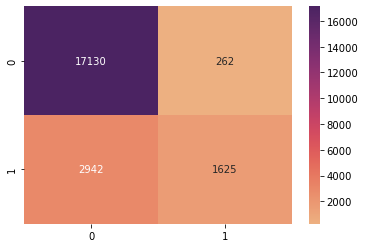

In [56]:
model_xg = GradientBoostingClassifier()
model_xg.fit(X_train, y_train)
print("Test score : ", model_xg.score(X_test, y_test))
y_pred_xg = model_xg.predict(X_test)
report_xg = classification_report(y_test, y_pred_xg)
print(f"Classification report : \n{report_xg}")
cm = confusion_matrix(y_test, y_pred_xg)
sns.heatmap(cm, annot=True,fmt='d',cmap="flare");

### AdaBoost

In [57]:
from sklearn.ensemble import AdaBoostClassifier

Test score :  0.8523156792203652
Classification report : 
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     17392
           1       0.85      0.35      0.50      4567

    accuracy                           0.85     21959
   macro avg       0.85      0.67      0.71     21959
weighted avg       0.85      0.85      0.83     21959



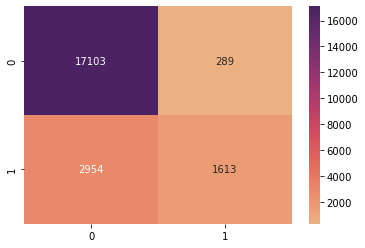

In [58]:
model_ada = AdaBoostClassifier()
model_ada.fit(X_train, y_train)
print("Test score : ", model_ada.score(X_test, y_test))
y_pred_ada = model_ada.predict(X_test)
report_ada = classification_report(y_test, y_pred_ada)
print(f"Classification report : \n{report_ada}")
cm = confusion_matrix(y_test, y_pred_ada)
sns.heatmap(cm, annot=True,fmt='d',cmap="flare");

### LinearSVC

In [59]:
from sklearn.svm import LinearSVC

Test score :  0.8484903684138622
Classification report : 
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     17392
           1       0.82      0.35      0.49      4567

    accuracy                           0.85     21959
   macro avg       0.84      0.66      0.70     21959
weighted avg       0.85      0.85      0.82     21959



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


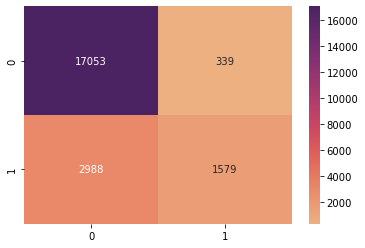

In [60]:
model_l = LinearSVC()
model_l.fit(X_train, y_train)
print("Test score : ", model_l.score(X_test, y_test))
y_pred_l = model_l.predict(X_test)
report_l = classification_report(y_test, y_pred_l)
print(f"Classification report : \n{report_l}")
cm = confusion_matrix(y_test, y_pred_l)
sns.heatmap(cm, annot=True,fmt='d',cmap="flare");

## Recherche des meilleurs hyperparamètres pour nos modèles sur un échantillon

In [62]:
from sklearn.model_selection import GridSearchCV

On ne prend qu'un échantillon de 5000 lignes pour la recherche d'hyperparamètres, pour que ce ne soit pas trop long.

In [63]:
df2 = df.sample(n=5000)
df2.shape

(5000, 113)

### Répartition des données


Si différents rendez-vous d'un même patient ont lieu en même temps dans les groupes d'entraînement et de test, une fuite de données peut se produire. On doit donc en tenir compte dans la répartition des données.

On enlève la colonne "**NoShow**" du jeu de données de prédiction.

In [64]:
X2 = df2.drop('NoShow', axis=1)

On supprime les colonnes "**Age**", "**WaitingDays**" and "**ScheduledHour**" car elles ont été normalisées. On utilisera donc les colonnes avec les données normalisées.

In [65]:
X2 = X2.drop(columns = ['Age', 'WaitingDays', 'ScheduledHour', 'PreviousAppointment', 'PreviousNoShow'], axis=1)

In [66]:
y2 = df2.NoShow

On prend **20%** des données pour le test et **80%** pour l'entraînement.

In [67]:
gs2 = GroupShuffleSplit(n_splits=2, test_size=.2, random_state=0)
train_ix2, test_ix2 = next(gs2.split(X2, y2, groups=X2.PatientID))

In [68]:
len(train_ix2)

4011

In [69]:
X_train2 = X2.iloc[train_ix2]
X_train2 = X_train2.drop('PatientID',1)
y_train2 = y2.iloc[train_ix2]

X_test2 = X2.iloc[test_ix2]
X_test2 = X_test2.drop('PatientID',1)
y_test2 = y2.iloc[test_ix2]

C:\Users\SALOMC~1\AppData\Local\Temp/ipykernel_29220/2407686821.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train2 = X_train2.drop('PatientID',1)
C:\Users\SALOMC~1\AppData\Local\Temp/ipykernel_29220/2407686821.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test2 = X_test2.drop('PatientID',1)


In [70]:
print("Train set data shape: " + str(X_train2.shape))
print("Test set data shape: " + str(X_test2.shape))

Train set data shape: (4011, 106)
Test set data shape: (989, 106)


### KNeighbors

In [71]:
param_grid = {'n_neighbors': np.arange(1, 30),'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train2, y_train2)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                         'weights': ['uniform', 'distance']})

#### Meilleure performance obtenue sur les données d'entraînement

In [72]:
grid.best_score_

0.8566435716437424

#### Meilleurs hyperparamètres

In [73]:
grid.best_params_

{'metric': 'euclidean', 'n_neighbors': 25, 'weights': 'distance'}

#### Performance obtenue sur les données de test

In [74]:
model_k2 = grid.best_estimator_
model_k2.score(X_test2, y_test2)

0.846309403437816

### Naive Bayes

In [73]:
param_grid_nb = {'var_smoothing': np.logspace(0, -9, num=100)}
grid_nb = GridSearchCV(GaussianNB(), param_grid_nb, cv=5)
grid_nb.fit(X_train2, y_train2)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])})

#### Meilleure performance obtenue sur les données d'entraînement

In [74]:
grid_nb.best_score_

0.8529976380249747

#### Meilleurs hyperparamètres

In [75]:
grid_nb.best_params_

{'var_smoothing': 0.8111308307896871}

#### Performance obtenue sur les données de test

In [96]:
model_nb2 = grid_nb.best_estimator_
model_nb2.score(X_test2, y_test2)

0.8599801390268124

### Decision tree

In [76]:
param_grid_dt = {'criterion': ['gini', 'entropy'], 'max_depth': np.arange(1, 30), 
                 'min_samples_leaf': np.arange(1, 5), 'ccp_alpha': [0, 0.1, 0.01, 0.001]}
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5)
grid_dt.fit(X_train2, y_train2)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0, 0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': array([1, 2, 3, 4])})

#### Meilleure performance obtenue sur les données d'entraînement

In [77]:
grid_dt.best_score_

0.8492407489311514

#### Meilleurs hyperparamètres

In [78]:
grid_dt.best_params_

{'ccp_alpha': 0.01,
 'criterion': 'gini',
 'max_depth': 25,
 'max_features': 'sqrt',
 'min_samples_leaf': 1}

#### Performance obtenue sur les données de test

In [97]:
model_dt2 = grid_dt.best_estimator_
model_dt2.score(X_test2, y_test2)

0.858987090367428

### Random forest

In [79]:
param_grid_rf = {'criterion': ['gini', 'entropy'], 'ccp_alpha': [0, 0.1, 0.01, 0.001], 'max_features': ['auto', 'sqrt', 'log2']}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5)
grid_rf.fit(X_train2, y_train2)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'ccp_alpha': [0, 0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2']})

#### Meilleure performance obtenue sur les données d'entraînement

In [80]:
grid_rf.best_score_

0.8552470036166764

#### Meilleurs hyperparamètres

In [81]:
grid_rf.best_params_

{'ccp_alpha': 0, 'criterion': 'entropy', 'max_features': 'sqrt'}

#### Performance obtenue sur les données de test

In [98]:
model_rf2 = grid_rf.best_estimator_
model_rf2.score(X_test2, y_test2)

0.8530287984111221

### XGboost

In [85]:
param_grid_xgb = {'loss': ['deviance', 'exponential'], 'criterion': ['friedman_mse', 'squared_error', 'mse'], 'ccp_alpha': [0, 0.1, 0.01, 0.001], 'max_features': ['auto', 'sqrt', 'log2']}
grid_xgb = GridSearchCV(GradientBoostingClassifier(), param_grid_xgb, cv=5)
grid_xgb.fit(X_train2, y_train2)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1252, in fit
    super().fit(
  File "C:\ProgramData\Anaconda3\lib\site

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'ccp_alpha': [0, 0.1, 0.01, 0.001],
                         'criterion': ['friedman_mse', 'squared_error', 'mse'],
                         'loss': ['deviance', 'exponential'],
                         'max_features': ['auto', 'sqrt', 'log2']})

#### Meilleure performance obtenue sur les données d'entraînement

In [86]:
grid_xgb.best_score_

0.8559995106665287

#### Meilleurs hyperparamètres

In [87]:
grid_xgb.best_params_

{'ccp_alpha': 0,
 'criterion': 'friedman_mse',
 'loss': 'exponential',
 'max_features': 'sqrt'}

#### Performance obtenue sur les données de test

In [100]:
model_xgb2 = grid_xgb.best_estimator_
model_xgb2.score(X_test2, y_test2)

0.8579940417080437

### AdaBoost

In [88]:
param_grid_ada = {'n_estimators': [10, 50, 100], 'learning_rate': [0.001, 0.01, 0.1, 1], 'algorithm': ['SAMME', 'SAMME.R']}
grid_ada = GridSearchCV(AdaBoostClassifier(), param_grid_ada, cv=5)
grid_ada.fit(X_train2, y_train2)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.001, 0.01, 0.1, 1],
                         'n_estimators': [10, 50, 100]})

#### Meilleure performance obtenue sur les données d'entraînement

In [89]:
grid_ada.best_score_

0.8562523329600598

#### Meilleurs hyperparamètres

In [90]:
grid_ada.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 100}

#### Performance obtenue sur les données de test

In [101]:
model_ada2 = grid_ada.best_estimator_
model_ada2.score(X_test2, y_test2)

0.8679245283018868

### LinearSVC

In [91]:
param_grid_l = {'penalty': ['l1', 'l2'], 'loss': ['hinge', 'squared_hinge'], 'multi_class': ['ovr', 'crammer_singer']}
grid_l = GridSearchCV(LinearSVC(), param_grid_l, cv=5)
grid_l.fit(X_train2, y_train2)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 830, in _get_liblinear_solver_type
    raise ValueError('Unsupported set of arguments: %s, '
ValueError: Unsupported set of arguments: The combination of penalt

GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'loss': ['hinge', 'squared_hinge'],
                         'multi_class': ['ovr', 'crammer_singer'],
                         'penalty': ['l1', 'l2']})

#### Meilleure performance obtenue sur les données d'entraînement

In [92]:
grid_l.best_score_

0.8489901223647353

#### Meilleurs hyperparamètres

In [93]:
grid_l.best_params_

{'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l2'}

#### Performance obtenue sur les données de test

In [102]:
model_l2 = grid_l.best_estimator_
model_l2.score(X_test2, y_test2)

0.8520357497517378

## Application des modèles avec les hyperparamètres trouvés sur l'ensemble du jeu de données

### KNeighbors

Test score :  0.8512227332756501
Classification report : 
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     17392
           1       0.82      0.36      0.50      4567

    accuracy                           0.85     21959
   macro avg       0.84      0.67      0.71     21959
weighted avg       0.85      0.85      0.83     21959



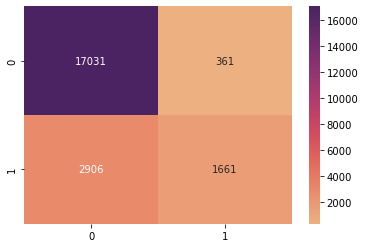

In [75]:
model_k3 = KNeighborsClassifier(metric='euclidean', n_neighbors=20, weights='distance')
model_k3.fit(X_train, y_train)
print("Test score : ", model_k3.score(X_test, y_test))
y_pred_k3 = model_k3.predict(X_test)
report_k3 = classification_report(y_test, y_pred_k3)
print(f"Classification report : \n{report_k3}")
cm = confusion_matrix(y_test, y_pred_k3)
sns.heatmap(cm, annot=True,fmt='d',cmap="flare");

### Naive Bayes

Test score :  0.849446696115488
Classification report : 
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     17392
           1       0.87      0.32      0.47      4567

    accuracy                           0.85     21959
   macro avg       0.86      0.66      0.69     21959
weighted avg       0.85      0.85      0.82     21959



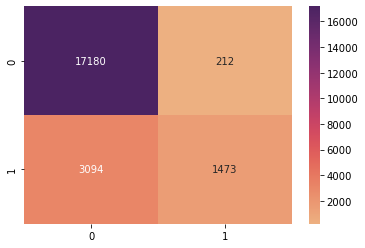

In [76]:
model_nb3 = GaussianNB(var_smoothing=0.8111308307896871)
model_nb3.fit(X_train, y_train)
print("Test score : ", model_nb3.score(X_test, y_test))
y_pred_nb3 = model_nb3.predict(X_test)
report_nb3 = classification_report(y_test, y_pred_nb3)
print(f"Classification report : \n{report_nb3}")
cm = confusion_matrix(y_test, y_pred_nb3)
sns.heatmap(cm, annot=True,fmt='d',cmap="flare");

### Decision Tree

Test score :  0.8494922355298511
Classification report : 
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     17392
           1       0.94      0.30      0.45      4567

    accuracy                           0.85     21959
   macro avg       0.89      0.65      0.68     21959
weighted avg       0.86      0.85      0.82     21959



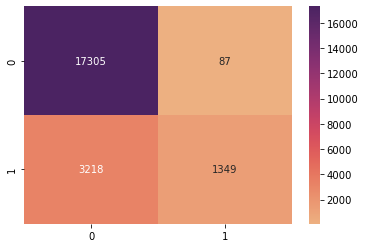

In [77]:
model_dt3 = DecisionTreeClassifier(ccp_alpha=0.01, criterion='gini', max_depth=25, min_samples_leaf=1)
model_dt3.fit(X_train, y_train)
print("Test score : ", model_dt3.score(X_test, y_test))
y_pred_dt3 = model_dt3.predict(X_test)
report_dt3 = classification_report(y_test, y_pred_dt3)
print(f"Classification report : \n{report_dt3}")
cm = confusion_matrix(y_test, y_pred_dt3)
sns.heatmap(cm, annot=True,fmt='d',cmap="flare");

### Random forest

Test score :  0.8512682726900133
Classification report : 
              precision    recall  f1-score   support

           0       0.86      0.97      0.91     17392
           1       0.77      0.41      0.53      4567

    accuracy                           0.85     21959
   macro avg       0.82      0.69      0.72     21959
weighted avg       0.84      0.85      0.83     21959



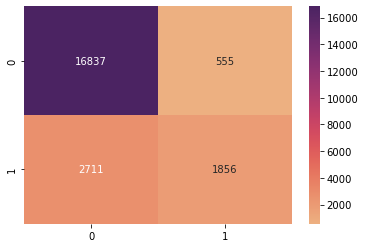

In [78]:
model_rf3 = RandomForestClassifier(ccp_alpha=0, criterion='entropy', max_features='sqrt')
model_rf3.fit(X_train, y_train)
print("Test score : ", model_rf3.score(X_test, y_test))
y_pred_rf3 = model_rf3.predict(X_test)
report_rf3 = classification_report(y_test, y_pred_rf3)
print(f"Classification report : \n{report_rf3}")
cm = confusion_matrix(y_test, y_pred_rf3)
sns.heatmap(cm, annot=True,fmt='d',cmap="flare");

### XGboost

Test score :  0.8513138121043763
Classification report : 
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     17392
           1       0.91      0.31      0.47      4567

    accuracy                           0.85     21959
   macro avg       0.88      0.65      0.69     21959
weighted avg       0.86      0.85      0.82     21959



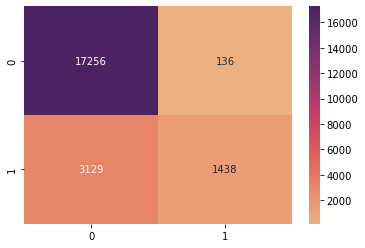

In [79]:
model_xg3 = GradientBoostingClassifier(ccp_alpha=0, criterion='friedman_mse', loss='exponential', max_features='sqrt')
model_xg3.fit(X_train, y_train)
print("Test score : ", model_xg3.score(X_test, y_test))
y_pred_xg3 = model_xg3.predict(X_test)
report_xg3 = classification_report(y_test, y_pred_xg3)
print(f"Classification report : \n{report_xg3}")
cm = confusion_matrix(y_test, y_pred_xg3)
sns.heatmap(cm, annot=True,fmt='d',cmap="flare");

### AdaBoost

Test score :  0.8523612186347284
Classification report : 
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     17392
           1       0.94      0.31      0.47      4567

    accuracy                           0.85     21959
   macro avg       0.89      0.65      0.69     21959
weighted avg       0.86      0.85      0.82     21959



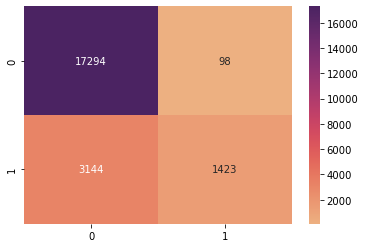

In [80]:
model_ada3 = AdaBoostClassifier(algorithm='SAMME.R', learning_rate=0.1, n_estimators=100)
model_ada3.fit(X_train, y_train)
print("Test score : ", model_ada3.score(X_test, y_test))
y_pred_ada3 = model_ada3.predict(X_test)
report_ada3 = classification_report(y_test, y_pred_ada3)
print(f"Classification report : \n{report_ada3}")
cm = confusion_matrix(y_test, y_pred_ada3)
sns.heatmap(cm, annot=True,fmt='d',cmap="flare");

### LinearSVC

Test score :  0.8489913019718567
Classification report : 
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     17392
           1       0.95      0.29      0.44      4567

    accuracy                           0.85     21959
   macro avg       0.90      0.64      0.68     21959
weighted avg       0.86      0.85      0.81     21959



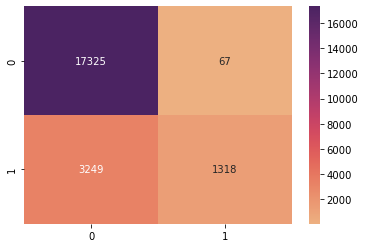

In [81]:
model_l3 = LinearSVC(loss='hinge', multi_class='ovr', penalty='l2')
model_l3.fit(X_train, y_train)
print("Test score : ", model_l3.score(X_test, y_test))
y_pred_l3 = model_l3.predict(X_test)
report_l3 = classification_report(y_test, y_pred_l3)
print(f"Classification report : \n{report_l3}")
cm = confusion_matrix(y_test, y_pred_l3)
sns.heatmap(cm, annot=True,fmt='d',cmap="flare");